# Лабораторная работа №1

**Dataset**:  
https://www.kaggle.com/datasets/amirmohamadrezaie/red-and-white-wine-quality/data  
This dataset merges the well-known red and white wine quality records into a single table that’s convenient for both regression (predicting quality) and classification (e.g., high vs. low quality, or predicting type). Each row is a wine sample with 11 physicochemical measurements, plus the quality score and wine type.

**At a glance**
Rows: 6,497
Columns: 13 (11 features + quality + type)  
Types (type): white = 4,898 (≈75.4%), red = 1,599 (≈24.6%)  
Target (quality): integer scores from 3 to 9  
Missing values: none  
**Columns**  
fixed acidity, volatile acidity, citric acid, residual sugar, chlorides,  
free sulfur dioxide, total sulfur dioxide, density, pH, sulphates,  
alcohol, quality, type  

**Suggested uses**  
Regression: Predict the numeric quality score from the 11 features.  
Binary/Multi-class classification: Threshold or bucketize quality (e.g., low/medium/high).  
Domain analysis: Compare physicochemical profiles across type (red vs. white).  
Feature importance & modeling: Try linear models, tree ensembles, and calibrated classifiers; evaluate with MAE/RMSE (regression) or F1/AUC   (classification).  
**File details**  
Format: CSV with header, comma-separated.  
Primary target: quality  
Auxiliary label: type (red, white)  
Acknowledgements: This is a merged version of the commonly used red and white wine quality datasets.  

In [23]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = "data\wine_quality_merged.csv"

data = pd.read_csv(DATA_PATH)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Формируем бинарную целевую переменную.  
Порог `quality >= 6` → класс 1 (хорошее), иначе 0 (плохое).  


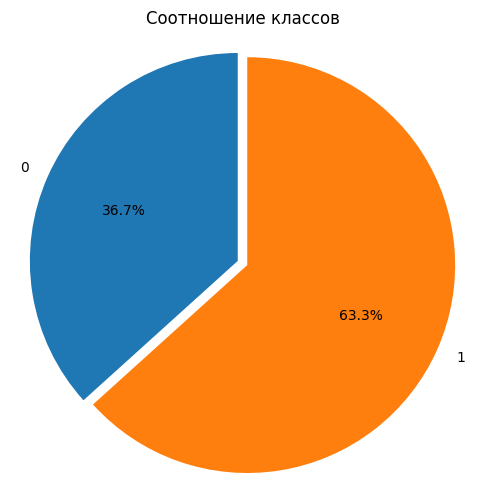

In [3]:
data['quality'] = (data['quality'] >= 6 ).astype(int)
class_counts = data['quality'].value_counts().sort_index()

labels = ['0', '1']

plt.figure(figsize=(6, 6))
plt.pie(
    class_counts, 
    labels=labels, 
    autopct='%1.1f%%',     
    startangle=90,         
    explode=(0.05, 0)  

)
plt.title('Соотношение классов')
plt.axis('equal')
plt.show()

In [4]:
y = data['quality']
X = data.drop(columns=['quality'])
X = X.dropna(axis=1, how="all")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

if num_cols:
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())
if cat_cols:
    for c in cat_cols:
        X[c] = X[c].fillna(X[c].mode().iloc[0])
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print(f"Фич: {X.shape[1]}, положительных: {int(y.sum())}, отрицательных: {int((1-y).sum())}")

Фич: 12, положительных: 4113, отрицательных: 2384


Присутствует дисбаланс классов - будем использовать методы борьбы с дисбалансом, а также соответсвтующие метрики (например, F1-score и ROC-AUC)

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# тут используем стратификацию, как способ борьбы с дисбалансом
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Собираем пайплайны  
Будем использовать kNN, LogReg, SVC, Random Forest, Gradient Boosting

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def make_pipeline_by_key(key: str):
    if key == "knn":
        model = KNeighborsClassifier()
        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    elif key == "rf":
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
        pipe = Pipeline([("model", model)])
    elif key == "logreg":
        model = LogisticRegression(random_state=RANDOM_STATE)
        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    elif key == "svc":
        model = SVC(random_state=RANDOM_STATE, probability=True)
        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    elif key == "gb":
        model = GradientBoostingClassifier(random_state=RANDOM_STATE)
        pipe = Pipeline([("model", model)])
    else:
        raise ValueError("Incorrect Name")
    return pipe

Задаем пространство поиска

In [7]:
from scipy.stats import randint, uniform, loguniform
search_spaces = {
    "knn": {
        "model__n_neighbors": randint(1, 51),
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],
    },
    "rf": {
        "model__n_estimators": randint(100, 801),
        "model__max_depth": randint(2, 25),
        "model__max_features": ["sqrt", "log2", None],
        "model__min_samples_split": randint(2, 21),
        "model__min_samples_leaf": randint(1, 11),
    },
    "logreg": {
        "model__C": loguniform(1e-3, 1e2),
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs", "liblinear"],
        "model__max_iter": [500, 1000, 2000],
    },
    "svc": {
        "model__C": loguniform(1e-3, 1e2),
        "model__gamma": loguniform(1e-4, 1e0),
        "model__kernel": ["rbf"],
        "model__probability": [True],
    },
    "gb": {
        "model__n_estimators": randint(50, 501),
        "model__learning_rate": loguniform(1e-3, 3e-1),
        "model__max_depth": randint(2, 6),
        "model__subsample": uniform(0.6, 0.4),
    },
}

Обертка для запуска оптимизации с помощью Optuna

In [8]:
import optuna
from optuna.samplers import TPESampler

def cv_score_auc(pipe, X, y, cv):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    return float(np.mean(scores)), scores

def build_optuna_search_space(trial, key: str):
    params = {}
    if key == "knn":
        params = {
            "model__n_neighbors": trial.suggest_int("knn_n_neighbors", 1, 50),
            "model__weights": trial.suggest_categorical("knn_weights", ["uniform","distance"]),
            "model__p": trial.suggest_categorical("knn_p", [1,2]),
        }
    elif key == "rf":
        params = {
            "model__n_estimators": trial.suggest_int("rf_n_estimators", 100, 800),
            "model__max_depth": trial.suggest_int("rf_max_depth", 2, 24),
            "model__max_features": trial.suggest_categorical("rf_max_features", ["sqrt","log2",None]),
            "model__min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 20),
            "model__min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 10),
        }
    elif key == "logreg":
        params = {
            "model__C": trial.suggest_float("logreg_C", 1e-3, 1e2, log=True),
            "model__penalty": trial.suggest_categorical("logreg_penalty", ["l2"]),
            "model__solver": trial.suggest_categorical("logreg_solver", ["lbfgs","liblinear"]),
            "model__max_iter": trial.suggest_categorical("logreg_max_iter", [500,1000,2000]),
        }
    elif key == "svc":
        params = {
            "model__C": trial.suggest_float("svc_C", 1e-3, 1e2, log=True),
            "model__gamma": trial.suggest_float("svc_gamma", 1e-4, 1e0, log=True),
            "model__kernel": trial.suggest_categorical("svc_kernel", ["rbf"]),
            "model__probability": True,
        }
    elif key == "gb":
        params = {
            "model__n_estimators": trial.suggest_int("gb_n_estimators", 50, 500),
            "model__learning_rate": trial.suggest_float("gb_learning_rate", 1e-3, 3e-1, log=True),
            "model__max_depth": trial.suggest_int("gb_max_depth", 2, 5),
            "model__subsample": trial.suggest_float("gb_subsample", 0.6, 1.0),
        }
    return params

def run_optuna_for_model(key: str, n_trials: int = 60, timeout_s: int = None):

    def objective(trial):
        pipe = make_pipeline_by_key(key)
        params = build_optuna_search_space(trial, key)
        pipe.set_params(**params)
        mean_auc, _ = cv_score_auc(pipe, X_train, y_train, cv)
        trial.set_user_attr("params", params)
        return mean_auc

    sampler = TPESampler(seed=RANDOM_STATE)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, timeout=timeout_s, show_progress_bar=False)
    best_params = study.best_trial.user_attrs.get("params", {})
    best_score = study.best_value
    print(f"[{key}] Optuna best ROC AUC = {best_score:.4f}")
    return study, best_params, best_score

In [9]:
optuna_results = {}
for key in ["knn","rf","logreg","svc","gb"]:
    study, params, score = run_optuna_for_model(key, n_trials=60, timeout_s=None)
    optuna_results[key] = {"study": study, "params": params, "score": score}

[I 2025-10-12 23:15:47,541] A new study created in memory with name: no-name-9ab82426-3298-45a8-9a35-2ce62f36db15
[I 2025-10-12 23:15:49,362] Trial 0 finished with value: 0.8185028583441106 and parameters: {'knn_n_neighbors': 19, 'knn_weights': 'uniform', 'knn_p': 1}. Best is trial 0 with value: 0.8185028583441106.
[I 2025-10-12 23:15:50,748] Trial 1 finished with value: 0.871948354748516 and parameters: {'knn_n_neighbors': 8, 'knn_weights': 'distance', 'knn_p': 2}. Best is trial 1 with value: 0.871948354748516.
[I 2025-10-12 23:15:52,083] Trial 2 finished with value: 0.784062123681571 and parameters: {'knn_n_neighbors': 2, 'knn_weights': 'uniform', 'knn_p': 1}. Best is trial 1 with value: 0.871948354748516.
[I 2025-10-12 23:15:53,459] Trial 3 finished with value: 0.8781748791927912 and parameters: {'knn_n_neighbors': 10, 'knn_weights': 'distance', 'knn_p': 1}. Best is trial 3 with value: 0.8781748791927912.
[I 2025-10-12 23:15:54,806] Trial 4 finished with value: 0.8878994204202808 an

[knn] Optuna best ROC AUC = 0.8926


[I 2025-10-12 23:15:59,820] Trial 0 finished with value: 0.8879994020046814 and parameters: {'rf_n_estimators': 362, 'rf_max_depth': 23, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 1}. Best is trial 0 with value: 0.8879994020046814.
[I 2025-10-12 23:16:02,808] Trial 1 finished with value: 0.8651895614251293 and parameters: {'rf_n_estimators': 707, 'rf_max_depth': 15, 'rf_max_features': None, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 3}. Best is trial 0 with value: 0.8879994020046814.
[I 2025-10-12 23:16:03,182] Trial 2 finished with value: 0.8327553011259579 and parameters: {'rf_n_estimators': 227, 'rf_max_depth': 6, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 7}. Best is trial 0 with value: 0.8879994020046814.
[I 2025-10-12 23:16:03,859] Trial 3 finished with value: 0.8507457231764934 and parameters: {'rf_n_estimators': 197, 'rf_max_depth': 8, 'rf_max_features': None, 'rf_min_samples_split': 5, 'rf_min_samples_

[rf] Optuna best ROC AUC = 0.8922


[I 2025-10-12 23:16:42,198] Trial 8 finished with value: 0.8016224690193775 and parameters: {'logreg_C': 0.5414413211338525, 'logreg_penalty': 'l2', 'logreg_solver': 'liblinear', 'logreg_max_iter': 1000}. Best is trial 3 with value: 0.801699021776227.
[I 2025-10-12 23:16:42,222] Trial 9 finished with value: 0.8016440109684965 and parameters: {'logreg_C': 0.9761125443110458, 'logreg_penalty': 'l2', 'logreg_solver': 'lbfgs', 'logreg_max_iter': 2000}. Best is trial 3 with value: 0.801699021776227.
[I 2025-10-12 23:16:42,248] Trial 10 finished with value: 0.8016264516172417 and parameters: {'logreg_C': 53.17196633982097, 'logreg_penalty': 'l2', 'logreg_solver': 'liblinear', 'logreg_max_iter': 2000}. Best is trial 3 with value: 0.801699021776227.
[I 2025-10-12 23:16:42,275] Trial 11 finished with value: 0.8013656906566082 and parameters: {'logreg_C': 0.035445487481142346, 'logreg_penalty': 'l2', 'logreg_solver': 'liblinear', 'logreg_max_iter': 1000}. Best is trial 3 with value: 0.8016990217

[logreg] Optuna best ROC AUC = 0.8017


[I 2025-10-12 23:16:45,170] Trial 0 finished with value: 0.8145114045772684 and parameters: {'svc_C': 0.0745934328572655, 'svc_gamma': 0.6351221010640696, 'svc_kernel': 'rbf'}. Best is trial 0 with value: 0.8145114045772684.
[I 2025-10-12 23:16:46,484] Trial 1 finished with value: 0.8248580497283001 and parameters: {'svc_C': 4.5705630998014515, 'svc_gamma': 0.024810409748678097, 'svc_kernel': 'rbf'}. Best is trial 1 with value: 0.8248580497283001.
[I 2025-10-12 23:16:47,988] Trial 2 finished with value: 0.7775823513316266 and parameters: {'svc_C': 0.006026889128682512, 'svc_gamma': 0.0004207053950287938, 'svc_kernel': 'rbf'}. Best is trial 1 with value: 0.8248580497283001.
[I 2025-10-12 23:16:49,532] Trial 3 finished with value: 0.8083977137925155 and parameters: {'svc_C': 0.0019517224641449498, 'svc_gamma': 0.29154431891537513, 'svc_kernel': 'rbf'}. Best is trial 1 with value: 0.8248580497283001.
[I 2025-10-12 23:16:50,794] Trial 4 finished with value: 0.8286939534975415 and parameter

[svc] Optuna best ROC AUC = 0.8448


[I 2025-10-12 23:18:23,752] Trial 0 finished with value: 0.8590737843187892 and parameters: {'gb_n_estimators': 218, 'gb_learning_rate': 0.22648248189516848, 'gb_max_depth': 4, 'gb_subsample': 0.8394633936788146}. Best is trial 0 with value: 0.8590737843187892.
[I 2025-10-12 23:18:24,181] Trial 1 finished with value: 0.7760927887244572 and parameters: {'gb_n_estimators': 120, 'gb_learning_rate': 0.0024345423962016913, 'gb_max_depth': 2, 'gb_subsample': 0.9464704583099741}. Best is trial 0 with value: 0.8590737843187892.
[I 2025-10-12 23:18:25,304] Trial 2 finished with value: 0.8333886333858483 and parameters: {'gb_n_estimators': 321, 'gb_learning_rate': 0.05675206026988748, 'gb_max_depth': 2, 'gb_subsample': 0.9879639408647978}. Best is trial 0 with value: 0.8590737843187892.
[I 2025-10-12 23:18:26,484] Trial 3 finished with value: 0.7952858895450812 and parameters: {'gb_n_estimators': 425, 'gb_learning_rate': 0.0033572967053517922, 'gb_max_depth': 2, 'gb_subsample': 0.673361803941373

[gb] Optuna best ROC AUC = 0.8719


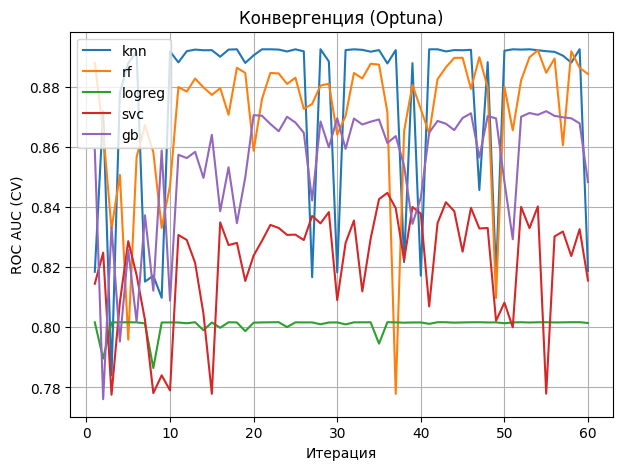

In [10]:
plt.figure(figsize=(7,5))
for key, res in optuna_results.items():
    st = res["study"]
    if st is None: 
        continue
    ys = [t.value for t in st.trials if t.value is not None]
    if not ys: 
        continue
    xs = np.arange(1, len(ys)+1)
    plt.plot(xs, ys, label=key)
plt.xlabel("Итерация"); plt.ylabel("ROC AUC (CV)"); plt.title("Конвергенция (Optuna)")
plt.grid(True); plt.legend(); plt.show()

Случайный поиск

In [11]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, average_precision_score, classification_report
from sklearn.metrics import make_scorer

rand_results = {}
for key in ["knn","rf","logreg","svc","gb"]:
    pipe = make_pipeline_by_key(key)
    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=search_spaces[key],
        n_iter=60,
        scoring="roc_auc",
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0,
        refit=True,
        error_score="raise"
    )
    rs.fit(X_train, y_train)
    rand_results[key] = {"best_params": rs.best_params_, "best_score": rs.best_score_}
    print(f"[{key}] RandomizedSearchCV best ROC AUC = {rs.best_score_:.4f}")

pd.DataFrame([[k, optuna_results[k]["score"], rand_results[k]["best_score"]] for k in ["knn","rf","logreg","svc","gb"]],
             columns=["model","optuna_auc","random_auc"]).sort_values("optuna_auc", ascending=False)


[knn] RandomizedSearchCV best ROC AUC = 0.8925
[rf] RandomizedSearchCV best ROC AUC = 0.8901
[logreg] RandomizedSearchCV best ROC AUC = 0.8017
[svc] RandomizedSearchCV best ROC AUC = 0.8360
[gb] RandomizedSearchCV best ROC AUC = 0.8689


,model,optuna_auc,random_auc
0,knn,0.892560,0.892534
1,rf,0.892245,0.890139
4,gb,0.871940,0.868868
3,svc,0.844768,0.836032
2,logreg,0.801721,0.801721


Результаты схожи :)

TPOT

In [16]:
from tpot import TPOTClassifier
from tpot import TPOTClassifier

common_kwargs = dict(
    generations=20,
    population_size=30,
    cv=cv,                
    random_state=RANDOM_STATE,
    n_jobs=6,
)

tpot = TPOTClassifier(
    **common_kwargs,
    scorers=["roc_auc"],       
    scorers_weights=[1.0],
)

tpot.fit(X_train, y_train)
preds = tpot.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score
tpot_score = roc_auc_score(y_test, preds)
print("TPOT ROC AUC (test):", tpot_score)

Generation: 100%|██████████| 20/20 [17:16<00:00, 51.82s/it]


TPOT ROC AUC (test): 0.9041714747141283


Финальные замеры

In [17]:
def fit_and_eval_on_test(key, params, metric="roc_auc"):
    pipe = make_pipeline_by_key(key)
    if params is not None:
        pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    if metric == "roc_auc":
        if hasattr(pipe.named_steps["model"], "predict_proba"):
            proba = pipe.predict_proba(X_test)[:,1]
        else:
            proba = pipe.decision_function(X_test)
        return roc_auc_score(y_test, proba)
    elif metric == "f1":
        preds = pipe.predict(X_test)
        return f1_score(y_test, preds)

summary_rows = []
for key in ["knn","rf","logreg","svc","gb"]:
    o_params = optuna_results.get(key,{}).get("params")
    r_params = rand_results.get(key,{}).get("best_params")
    o_test = fit_and_eval_on_test(key, o_params, metric="roc_auc") if o_params else None
    r_test = fit_and_eval_on_test(key, r_params, metric="roc_auc") if r_params else None
    summary_rows.append([key, optuna_results.get(key,{}).get("score"), o_test,
                         rand_results.get(key,{}).get("best_score"), r_test])

summary_df = pd.DataFrame(summary_rows, columns=[
    "model","optuna_cv_auc","optuna_test_auc","random_cv_auc","random_test_auc"
])
display(summary_df.sort_values("optuna_cv_auc", ascending=False))

if tpot_score is not None:
    print(f"TPOT test ROC AUC: {tpot_score:.4f}")


,model,optuna_cv_auc,optuna_test_auc,random_cv_auc,random_test_auc
0,knn,0.892560,0.907764,0.892534,0.908648
1,rf,0.892245,0.908168,0.890139,0.906183
4,gb,0.871940,0.895795,0.868868,0.887124
3,svc,0.844768,0.850844,0.836032,0.843582
2,logreg,0.801721,0.805584,0.801721,0.805617


TPOT test ROC AUC: 0.9042


Альтернативная метрика - F1-score

In [18]:

def cv_score_f1(pipe, X, y, cv):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1", n_jobs=-1)
    return float(np.mean(scores)), scores

def run_optuna_for_model_f1(key: str, n_trials: int = 40, timeout_s: int = None):
    
    def objective(trial):
        pipe = make_pipeline_by_key(key)
        params = build_optuna_search_space(trial, key)
        pipe.set_params(**params)
        mean_f1, _ = cv_score_f1(pipe, X_train, y_train, cv)
        trial.set_user_attr("params", params)
        return mean_f1

    sampler = TPESampler(seed=RANDOM_STATE)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, timeout=timeout_s, show_progress_bar=False)

    best_params = study.best_trial.user_attrs.get("params", {})
    best_score = study.best_value
    print(f"[{key}] Optuna best F1 = {best_score:.4f}")
    return study, best_params, best_score

optuna_f1_results = {}
for key in ["knn","rf","logreg","svc","gb"]:
    study, params, score = run_optuna_for_model_f1(key, n_trials=40)
    optuna_f1_results[key] = {"study": study, "params": params, "score": score}

pd.DataFrame([[k, optuna_results[k]["params"], optuna_f1_results[k]["params"]] for k in ["knn","rf","logreg","svc","gb"]],
             columns=["model","best_params_auc","best_params_f1"])


[I 2025-10-12 23:47:29,562] A new study created in memory with name: no-name-b79d0d0b-efe8-499a-b0ac-b76117729b73
[I 2025-10-12 23:47:47,774] Trial 0 finished with value: 0.8144143878130766 and parameters: {'knn_n_neighbors': 19, 'knn_weights': 'uniform', 'knn_p': 1}. Best is trial 0 with value: 0.8144143878130766.
[I 2025-10-12 23:47:49,127] Trial 1 finished with value: 0.8434740987712537 and parameters: {'knn_n_neighbors': 8, 'knn_weights': 'distance', 'knn_p': 2}. Best is trial 1 with value: 0.8434740987712537.
[I 2025-10-12 23:47:50,526] Trial 2 finished with value: 0.7643806853259727 and parameters: {'knn_n_neighbors': 2, 'knn_weights': 'uniform', 'knn_p': 1}. Best is trial 1 with value: 0.8434740987712537.
[I 2025-10-12 23:47:51,909] Trial 3 finished with value: 0.8492622935200338 and parameters: {'knn_n_neighbors': 10, 'knn_weights': 'distance', 'knn_p': 1}. Best is trial 3 with value: 0.8492622935200338.
[I 2025-10-12 23:47:53,270] Trial 4 finished with value: 0.851576838724829

[knn] Optuna best F1 = 0.8556


[I 2025-10-12 23:47:57,104] Trial 0 finished with value: 0.8571278239302244 and parameters: {'rf_n_estimators': 362, 'rf_max_depth': 23, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 1}. Best is trial 0 with value: 0.8571278239302244.
[I 2025-10-12 23:48:00,138] Trial 1 finished with value: 0.8404624641829763 and parameters: {'rf_n_estimators': 707, 'rf_max_depth': 15, 'rf_max_features': None, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 3}. Best is trial 0 with value: 0.8571278239302244.
[I 2025-10-12 23:48:00,518] Trial 2 finished with value: 0.8226675980518564 and parameters: {'rf_n_estimators': 227, 'rf_max_depth': 6, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 7}. Best is trial 0 with value: 0.8571278239302244.
[I 2025-10-12 23:48:01,229] Trial 3 finished with value: 0.8333378488734764 and parameters: {'rf_n_estimators': 197, 'rf_max_depth': 8, 'rf_max_features': None, 'rf_min_samples_split': 5, 'rf_min_samples_

[rf] Optuna best F1 = 0.8594


[I 2025-10-12 23:48:34,260] Trial 7 finished with value: 0.803423035559552 and parameters: {'logreg_C': 0.0014857392806279248, 'logreg_penalty': 'l2', 'logreg_solver': 'lbfgs', 'logreg_max_iter': 500}. Best is trial 5 with value: 0.8064324436718753.
[I 2025-10-12 23:48:34,285] Trial 8 finished with value: 0.805970199111216 and parameters: {'logreg_C': 0.5414413211338525, 'logreg_penalty': 'l2', 'logreg_solver': 'liblinear', 'logreg_max_iter': 1000}. Best is trial 5 with value: 0.8064324436718753.
[I 2025-10-12 23:48:34,311] Trial 9 finished with value: 0.8064324436718753 and parameters: {'logreg_C': 0.9761125443110458, 'logreg_penalty': 'l2', 'logreg_solver': 'lbfgs', 'logreg_max_iter': 2000}. Best is trial 5 with value: 0.8064324436718753.
[I 2025-10-12 23:48:34,337] Trial 10 finished with value: 0.8057958420194306 and parameters: {'logreg_C': 59.57690615744496, 'logreg_penalty': 'l2', 'logreg_solver': 'liblinear', 'logreg_max_iter': 1000}. Best is trial 5 with value: 0.80643244367187

[logreg] Optuna best F1 = 0.8073


[I 2025-10-12 23:48:36,873] Trial 0 finished with value: 0.7843555074014369 and parameters: {'svc_C': 0.0745934328572655, 'svc_gamma': 0.6351221010640696, 'svc_kernel': 'rbf'}. Best is trial 0 with value: 0.7843555074014369.
[I 2025-10-12 23:48:38,219] Trial 1 finished with value: 0.819489447798248 and parameters: {'svc_C': 4.5705630998014515, 'svc_gamma': 0.024810409748678097, 'svc_kernel': 'rbf'}. Best is trial 1 with value: 0.819489447798248.
[I 2025-10-12 23:48:39,765] Trial 2 finished with value: 0.775303469782815 and parameters: {'svc_C': 0.006026889128682512, 'svc_gamma': 0.0004207053950287938, 'svc_kernel': 'rbf'}. Best is trial 1 with value: 0.819489447798248.
[I 2025-10-12 23:48:41,313] Trial 3 finished with value: 0.775303469782815 and parameters: {'svc_C': 0.0019517224641449498, 'svc_gamma': 0.29154431891537513, 'svc_kernel': 'rbf'}. Best is trial 1 with value: 0.819489447798248.
[I 2025-10-12 23:48:42,689] Trial 4 finished with value: 0.8186692856492416 and parameters: {'s

[svc] Optuna best F1 = 0.8357


[I 2025-10-12 23:49:43,703] Trial 0 finished with value: 0.8422781380007118 and parameters: {'gb_n_estimators': 218, 'gb_learning_rate': 0.22648248189516848, 'gb_max_depth': 4, 'gb_subsample': 0.8394633936788146}. Best is trial 0 with value: 0.8422781380007118.
[I 2025-10-12 23:49:44,137] Trial 1 finished with value: 0.775303469782815 and parameters: {'gb_n_estimators': 120, 'gb_learning_rate': 0.0024345423962016913, 'gb_max_depth': 2, 'gb_subsample': 0.9464704583099741}. Best is trial 0 with value: 0.8422781380007118.
[I 2025-10-12 23:49:45,303] Trial 2 finished with value: 0.8252109623034608 and parameters: {'gb_n_estimators': 321, 'gb_learning_rate': 0.05675206026988748, 'gb_max_depth': 2, 'gb_subsample': 0.9879639408647978}. Best is trial 0 with value: 0.8422781380007118.
[I 2025-10-12 23:49:46,492] Trial 3 finished with value: 0.8012848016670144 and parameters: {'gb_n_estimators': 425, 'gb_learning_rate': 0.0033572967053517922, 'gb_max_depth': 2, 'gb_subsample': 0.6733618039413735

[gb] Optuna best F1 = 0.8526


,model,best_params_auc,best_params_f1
0,knn,"{'model__n_neighbors': 46, 'model__weights': '...","{'model__n_neighbors': 46, 'model__weights': '..."
1,rf,"{'model__n_estimators': 269, 'model__max_depth...","{'model__n_estimators': 676, 'model__max_depth..."
2,logreg,"{'model__C': 0.12679298359082988, 'model__pena...","{'model__C': 0.03675544581625172, 'model__pena..."
3,svc,"{'model__C': 1.4725476150244998, 'model__gamma...","{'model__C': 1.079705725651322, 'model__gamma'..."
4,gb,"{'model__n_estimators': 457, 'model__learning_...","{'model__n_estimators': 339, 'model__learning_..."


Влияние сложности задачи

In [19]:

def run_optuna_scenario(key: str, scenario: str, base_best: dict = None, n_trials: int = 60, timeout_s: int = 300):
    
    def objective(trial):
        pipe = make_pipeline_by_key(key)
        if scenario == "dummy":
            params = build_optuna_search_space(trial, key)
            _ = trial.suggest_float("dummy_noise_real", 0.0, 1.0)
            _ = trial.suggest_int("dummy_noise_int", 0, 100)
            _ = trial.suggest_categorical("dummy_cat", ["a","b","c"])
        elif scenario == "wide":
            if key == "rf":
                params = {
                    "model__n_estimators": trial.suggest_int("rf_n_estimators", 50, 1500),
                    "model__max_depth": trial.suggest_int("rf_max_depth", 2, 60),
                    "model__max_features": trial.suggest_categorical("rf_max_features", ["sqrt","log2",None, 0.4, 0.6, 0.8]),
                    "model__min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 50),
                    "model__min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 30),
                }
            else:
                params = build_optuna_search_space(trial, key)
        elif scenario == "narrow":
            if base_best is None:
                params = build_optuna_search_space(trial, key)
            else:
                if key == "rf":
                    ne = base_best.get("model__n_estimators", 200)
                    md = base_best.get("model__max_depth", 8)
                    msl = base_best.get("model__min_samples_leaf", 2)
                    mss = base_best.get("model__min_samples_split", 2)
                    params = {
                        "model__n_estimators": trial.suggest_int("rf_n_estimators", max(50, ne-50), ne+50),
                        "model__max_depth": trial.suggest_int("rf_max_depth", max(2, md-3), md+3),
                        "model__max_features": trial.suggest_categorical("rf_max_features", ["sqrt","log2",None]),
                        "model__min_samples_split": trial.suggest_int("rf_min_samples_split", max(2, mss-3), mss+3),
                        "model__min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", max(1, msl-2), msl+2),
                    }
                else:
                    params = build_optuna_search_space(trial, key)
        else:
            params = build_optuna_search_space(trial, key)

        pipe.set_params(**params)
        mean_auc, _ = cv_score_auc(pipe, X_train, y_train, cv)
        return mean_auc

    sampler = TPESampler(seed=RANDOM_STATE)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, timeout=timeout_s, show_progress_bar=False)
    return study

base_best_rf = optuna_results.get("rf",{}).get("params")

scenarios = {}

scenarios["dummy"]  = run_optuna_scenario("rf", "dummy", base_best_rf, n_trials=60, timeout_s=300)
scenarios["wide"]   = run_optuna_scenario("rf", "wide", base_best_rf, n_trials=60, timeout_s=300)
scenarios["narrow"] = run_optuna_scenario("rf", "narrow", base_best_rf, n_trials=60, timeout_s=300)

scenarios["logreg_simple"] = run_optuna_scenario("logreg", "different_complexity", None, n_trials=60, timeout_s=300)
scenarios["rf_complex"]    = run_optuna_scenario("rf", "different_complexity", None, n_trials=60, timeout_s=300)

[I 2025-10-12 23:52:25,992] A new study created in memory with name: no-name-f977d324-80f8-4d92-8869-f0afa49309d8
[I 2025-10-12 23:52:26,762] Trial 0 finished with value: 0.8879994020046814 and parameters: {'rf_n_estimators': 362, 'rf_max_depth': 23, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 1, 'dummy_noise_real': 0.8661761457749352, 'dummy_noise_int': 60, 'dummy_cat': 'c'}. Best is trial 0 with value: 0.8879994020046814.
[I 2025-10-12 23:52:28,532] Trial 1 finished with value: 0.833800397875519 and parameters: {'rf_n_estimators': 683, 'rf_max_depth': 6, 'rf_max_features': None, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 5, 'dummy_noise_real': 0.2912291401980419, 'dummy_noise_int': 61, 'dummy_cat': 'c'}. Best is trial 0 with value: 0.8879994020046814.
[I 2025-10-12 23:52:30,182] Trial 2 finished with value: 0.8643078263707624 and parameters: {'rf_n_estimators': 419, 'rf_max_depth': 20, 'rf_max_features': None, 'rf_min_samples_split': 2, 'rf_mi

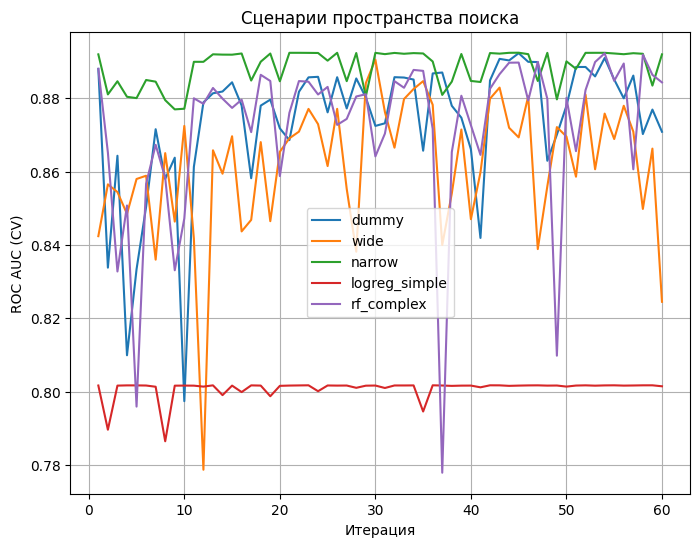

plot_param_importances недоступно  Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.


In [21]:
plt.figure(figsize=(8,6))
for name, st in scenarios.items():
    ys = [t.value for t in st.trials if t.value is not None]
    xs = np.arange(1, len(ys)+1)
    plt.plot(xs, ys, label=name)
plt.xlabel("Итерация"); plt.ylabel("ROC AUC (CV)"); plt.title("Сценарии пространства поиска")
plt.grid(True); plt.legend(); plt.show()

try:
    from optuna.visualization import plot_param_importances
    fig = plot_param_importances(scenarios["rf_complex"])
    fig.show()
except Exception as e:
    print("plot_param_importances недоступно ", e)


Финальные метрики

In [22]:
best_record = None
for key in ["knn","rf","logreg","svc","gb"]:
    o = optuna_results.get(key,{}).get("score")
    if o is not None:
        best_record = max(best_record or (-1,None,None,None), (o, "optuna", key, optuna_results[key]["params"]))
    r = rand_results.get(key,{}).get("best_score")
    if r is not None:
        best_record = max(best_record or (-1,None,None,None), (r, "random", key, rand_results[key]["best_params"]))

best_cv, method, key, params = best_record
print(f"Лучшая по CV ROC AUC: {best_cv:.4f} | метод: {method} | модель: {key}")
final_pipe = make_pipeline_by_key(key)
final_pipe.set_params(**params)
final_pipe.fit(X_train, y_train)

if hasattr(final_pipe.named_steps["model"], "predict_proba"):
    proba = final_pipe.predict_proba(X_test)[:,1]
else:
    proba = final_pipe.decision_function(X_test)

preds = (proba >= 0.5).astype(int)
print("Test ROC AUC:", roc_auc_score(y_test, proba))
print("Test F1:", f1_score(y_test, preds))
print("Test Accuracy:", accuracy_score(y_test, preds))
print("\nClassification report:\n", classification_report(y_test, preds))


Лучшая по CV ROC AUC: 0.8926 | метод: optuna | модель: knn
Test ROC AUC: 0.9077644553469308
Test F1: 0.8651428571428571
Test Accuracy: 0.8184615384615385

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.64      0.72       477
           1       0.82      0.92      0.87       823

    accuracy                           0.82      1300
   macro avg       0.82      0.78      0.79      1300
weighted avg       0.82      0.82      0.81      1300

